<h1>Distributed Federated Learning with MNIST Data</h1>

<b>Importing the libraries</b>

<ul>
<li> Pytorch (to train the model)
<li> Pysyft (to train using federated approach)
</ul>

In [1]:
import pickle
import itertools
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import syft as sy
from syft.frameworks.torch.fl import utils
import pandas as pd
import itertools
import random
import datetime

In [2]:
#torch.multiprocessing.set_start_method('spawn')
#torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
class Parser:
     def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 200
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        self.num_of_workers = 10
    
args = Parser()
#torch.manual_seed(args.seed)
#kwargs = {'num_workers': 1, 'pin_memory': False}

use_cuda = not args.no_cuda and torch.cuda.is_available()

#torch.set_default_tensor_type(torch.cuda.FloatTensor)

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if not use_cuda else {}
print(use_cuda)

False


<b>Download MNIST Data using torchvision datasets module</b>

In [4]:
train_loader = DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    #.federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=1, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

<b>Creating architecture of the Neural Network model</b>

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.previous_accuracy = 0
        self.previous_params = {}

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def federated_avg(self, neighbour_model_params=None, current_worker=None):
        #Average two models weights
        
        
        
        params1 = self.state_dict()
        #print(self.previous_params, params1)
        params2 = neighbour_model_params #neighbour_model_params.copy()
      
        with torch.no_grad():
            for name1 in params1:
                if name1 in params2:
                    #print("######", params2[name1].shape, params2[name1])
                    neighbour_ptr = params2[name1].copy()
                    neighbour_ptr.move(current_worker)
                    #print(name1, params1[name1].shape, neighbour_ptr.shape)
                    
                    params1[name1] = (params1[name1]  + neighbour_ptr)/2
                    #x = params1[name1].copy()
                    #x.get()
                    #print("parameter value", x)
        
        #for key, value in params1.items():
        #    print(key, value.shape)
        
                    
        #self.load_state_dict(params1, strict=False)
        self.load_state_dict(params1)
                             
        
    def federated_avg_multi(self, neighbour_model_params, current_worker=None):
    
        if len(neighbour_model_params) == 1:
            self.federated_avg(neighbour_model_params[0], current_worker)
        else:
            params1 = self.state_dict()
            for params2 in neighbour_model_params: 
                #params2 = neighbour_model_params #neighbour_model_params.copy()
                with torch.no_grad():
                    for name1 in params1:
                        if name1 in params2:
                            neighbour_ptr = params2[name1].copy()
                            neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                            params1[name1] = params1[name1]  + neighbour_ptr
            
            #Averaging model weights
            scale = len(neighbour_model_params) + 1
            with torch.no_grad():
                for name in params1:
                    #print("#######param  ", name)
                    params1[name] = params1[name] / scale
                
            #Load back new params to model        
            #self.load_state_dict(params1, strict=False)
            self.load_state_dict(params1)
        
    def rollback_exchange(self):
        self.load_state_dict(self.previous_params, strict=False)
    

In [6]:
#Create events list for virutal workers exchange of parameters.
def create_events(num_of_workers):
    worker_events = list(itertools.combinations(range(1,num_of_workers+1),2))
    random.shuffle(worker_events)
    
    events_df = pd.DataFrame(worker_events,columns=['worker_id1','worker_id2'])
    events_df.index.names = ["batchnum"]
    return events_df

In [7]:
events_df = create_events(args.num_of_workers)
events_df

,worker_id1,worker_id2
batchnum,,
0,6,10
1,1,2
2,4,7
3,1,9
4,2,10
5,2,8
6,5,6
7,2,7
8,1,4


<b>Initilizer Function to create Virtual workers, initiate models and optimizers. Data will split amongst workers and trained.</b>

In [15]:
def rotate_tuple_worker(worker_tuple):
    return worker_tuple[1:] + [worker_tuple[0]]

def generate_worker_split():
    random.seed(1)
    target_worker_split = {}
    total_mnist_numbers = 10
    mnist_numbers = list(range(10))
    for i in range(args.num_of_workers):
        mnist_worker_number = random.sample(mnist_numbers, 3)
        
        for mnist_number in mnist_worker_number:
            if mnist_number in target_worker_split:
                target_worker_split[mnist_number].append(i)
            else:
                target_worker_split[mnist_number] = []
                target_worker_split[mnist_number].append(i)
    
    return target_worker_split
            
    
def initialize_workers():
    hook = sy.TorchHook(torch)
    compute_nodes = [sy.VirtualWorker(hook, id=f"worker-{i}") for i in range(args.num_of_workers)]
    remote_dataset = tuple(list() for _ in range(args.num_of_workers))
    input_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_counter = {}
    ##target_worker_split = {0:0, 1:1, 2:(2,0), 3:1, 4:0, 5:1, 6:2, 7:1, 8:(2,0), 9:2 }  ##target values for 3 workers
    #target_worker_split = {0:0, 1:1, 2:0, 3:1, 4:(1,0), 5:(1,0), 6:(0,1), 7:1, 8:(0,1), 9:0 }    ##target values for 2 workers
    #target_worker_split = {0:0, 1:1, 2:2, 3:0, 4:2, 5:1, 6:2, 7:0, 8:1, 9:2 }
    target_worker_split = generate_worker_split()
    print(target_worker_split)
    for batch_idx, (data,target) in enumerate(train_loader):
        target_value = target.item()
        
        if isinstance(target_worker_split[target_value], list):
            current_worker_idx = target_worker_split[target_value][0]
            target_worker_split[target_value] = rotate_tuple_worker(target_worker_split[target_value])
        else:
            current_worker_idx = target_worker_split[target_value]
        
        #for current_worker_idx in target_worker_split[target_value]:
        if len(target_worker_dataset[current_worker_idx]) == args.batch_size:
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            #cuda#target_values = torch.cat(target_values).to(device)
            input_data = torch.cat(input_data)
            #cuda#input_data = torch.cat(input_data).to(device)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
                      
        target_worker_dataset[current_worker_idx].append((data, target))
            
    for current_worker_idx in range(args.num_of_workers):
        if len(target_worker_dataset[current_worker_idx]):
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            #cuda#target_values = torch.cat(target_values).to(device)
            input_data = torch.cat(input_data)
            #cuda#input_data = torch.cat(input_data).to(device)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
        
    models = [Net() for _ in range(args.num_of_workers)]
    #for model in models:
    #    model.to(device)
    optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    return compute_nodes, remote_dataset, models, optimizers


In [9]:
def update(data, target, model, optimizer):
    #print(data, target)
    #for key, value in model.state_dict().items():
    #    print(model, key, value, value.shape)
    #CUDA#data, target = data.to(device), target.to(device)
    #print(data, target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    
            
    return model, data, target

In [10]:
def check_accuracy(model, node):
    model.get()
    _, accuracy = test(model, node.id)
    return accuracy, model.send(node)

def exchange_parameters(models, data_index):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    event_idx = data_index % len(events_df)
    event_row = events_df.loc[[event_idx]]
    worker_id1 = event_row['worker_id1'].values[0]-1
    worker_id2 = event_row['worker_id2'].values[0]-1
    worker1_model = models[worker_id1]
    worker2_model = models[worker_id2]
    worker1_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
    worker2_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
    
    #Send worker2 params to worker1 for averaging at worker1
    #accuracy_before_exchange, models[worker_id1]  = check_accuracy(worker1_model, compute_nodes[worker_id1])
    
    worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
    accuracy_after_exchange, models[worker_id1]  = check_accuracy(worker1_model, compute_nodes[worker_id1])

    #print("#########Node - {} accuracy before exchange - {} ; accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[worker_id1], accuracy_before_exchange, accuracy_after_exchange, worker1_model.previous_accuracy ))
    
    if accuracy_after_exchange < worker1_model.previous_accuracy:
        worker1_model.rollback_exchange()
    else:
        worker1_model.previous_accuracy = accuracy_after_exchange
        worker1_model.previous_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
        
    
    #Send worker1 params to worker2 for averaging at worker2
    #accuracy_before_exchange, models[worker_id2]  = check_accuracy(worker2_model, compute_nodes[worker_id2])
    
    worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])
    #model_copy = worker2_model.copy()
    accuracy_after_exchange, models[worker_id2]  = check_accuracy(worker2_model, compute_nodes[worker_id2])
    #print("###########Node - {} accuracy before exchange - {} ;  accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[worker_id2], accuracy_before_exchange, accuracy_after_exchange, worker2_model.previous_accuracy ))
    if accuracy_after_exchange < worker2_model.previous_accuracy:
        worker2_model.rollback_exchange()
    else:
        worker2_model.previous_accuracy = accuracy_after_exchange
        worker2_model.previous_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
        
    return worker_id1, worker_id2

def exchange_parameters_all(models, data_index):
    exchange_combinations = list(itertools.combinations(range(len(models)), 2))
    random.shuffle(exchange_combinations)
    
    worker_list = list(range(len(compute_nodes)))
    
    
    for worker_id1, worker_id2 in exchange_combinations:
    #for worker_id1, worker_id2 in zip(worker_list, worker_list[1:] + [worker_list[0]]):
        worker1_model = models[worker_id1]
        worker2_model = models[worker_id2]
        #print("####MODELS",worker_id1, worker1_model, worker_id2, worker2_model)
        #for key, value in worker1_model.state_dict().items():
        #    print(worker_id1, key, value, value.shape)
            
        #for key, value in worker2_model.state_dict().items():
        #    print(worker_id2, key, value, value.shape)
            
        worker1_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
        worker2_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
        worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
        worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])
        
        

def exchange_parameters_multiple(models, data_index=None):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    #current_worker_idx = data_index % len(compute_nodes)
    #worker1_model = models[current_worker_idx]
    #worker1_params = worker1_model.state_dict().copy()
    worker_params = [model.state_dict().copy() for model in models]
    idx = 0
    
    for node in compute_nodes:
        other_worker_params = [param for i, param in enumerate(worker_params) if i != idx ]
        models[idx].federated_avg_multi(other_worker_params, compute_nodes[idx])
        idx += 1
    
        
    
    ##Copy the model to other workers
    #new_models = [] #[worker1_model.copy().move(node) for i, node in enumerate(compute_nodes) if i != current_worker_idx]
    #for i, node in enumerate(compute_nodes):
    #    if i == current_worker_idx:
    #        print("###CURRENT######", type(worker1_model), node, worker1_model)
    #        new_models.append(worker1_model)
    #    else:
    #        neighbour_model_ptr = worker1_model.copy()
    #        print("###other######", type(neighbour_model_ptr), node, worker1_model.location, neighbour_model_ptr)
    #        neighbour_model_ptr.move(node)
    #        new_models.append(neighbour_model_ptr)
    #        print("###After mive######", type(neighbour_model_ptr), node, neighbour_model_ptr)
    
    #return new_models
    
   

In [11]:
def train(models, compute_nodes, remote_dataset, optimizers, epoch_id, federated_average=False, decentralized=False):
    
    #for key, value in models[0].state_dict().items():
    #    print("BEFORE START - 0",models[0], key, value, value.shape)
    
    #for key, value in models[59].state_dict().items():
    #    print("before START - 59", models[59], key, value, value.size())
    
    #print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n", models[59].to(device), models[59].to(device).state_dict())
    
    if federated_average:
        #cuda#models = [models.copy().to(device) for _ in range(args.num_of_workers)]
        models = [models.copy() for _ in range(args.num_of_workers)]
        optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    
    #for key, value in models[59].state_dict().items():
    #    print("before START - 59", models[59], key, value, value.size())
        
    #models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    
    #print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n")
    #for key, value in models[59].state_dict().items():
    #    print("AFTER SEND- 59", models[59], key, value, value.size())
    
    
    #print("#############################")
    
    for remote_index in range(len(compute_nodes)):
        #print(f"Trip {data_index} and length of remote_dataset in {len(remote_dataset[0])} {len(remote_dataset[1])} {len(remote_dataset[2])}")
        for data_index in range(len(remote_dataset[remote_index])):
            data, target = remote_dataset[remote_index][data_index]
            models[remote_index], data, target = update(data, target, models[remote_index], optimizers[remote_index])
            remote_dataset[remote_index][data_index] = (data, target)
        
    
       #Exchange of parameter between two remote models.
    if decentralized:
        #worker_id1, worker_id2 = exchange_parameters(models, epoch_id)
        exchange_parameters_all(models, epoch_id)
        #for i in range(len(models)):
        #    if i not in (worker_id1, worker_id2):
        #        print(i, worker_id1, worker_id2)
        #        accuracy, models[i] = check_accuracy(models[i], compute_nodes[i])
        #        if accuracy < models[i].previous_accuracy:
        #            models[i].rollback_exchange()
                
        #exchange_parameters_multiple(models, epoch_id)
        
        
    for i, model in enumerate(models):
        model.get()
        #if federated_average:
        #    _, current_accuracy = test(model, compute_nodes[i])
        #    print("###########Federated Average Node - {}  accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[i], current_accuracy, model.previous_accuracy ))
        #    model.previous_accuracy = current_accuracy
        
        
    
    #if exchange:
    #    return models
        
    #Federated Average
    if federated_average:
        model =  utils.federated_avg({f"worker-{i}":models[i] for i in range(len(compute_nodes))})
        return model

In [12]:
def test(federated_model, worker_id):
    federated_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            #cuda#data, target = data.to(device), target.to(device)
            output = federated_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
           
        
    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)
    #print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_id, test_loss, avg_correct))
    return test_loss, avg_correct
    

In [13]:
def run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=False):
    model = Net()
    
    eval_results = []
    for epoch in range(args.epochs):
        start_time = time.time()
        print(f"Epoch Number {epoch + 1}")
        

        if decentralized:
            #models = train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_node.id, avg_loss, avg_accuracy))
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
        elif federated_average:
            
            federated_model = train(model, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            avg_loss, avg_accuracy = test(federated_model, "federated_avg_local")
            print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format("federated_avg_local", avg_loss, avg_accuracy))
            results = {"worker_id" : "federated_avg_local",
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
            eval_results.append(results)
            model = federated_model
        else:
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_node.id, avg_loss, avg_accuracy))
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
            
        total_time = time.time() - start_time
        print('Communication time over the network', round(total_time, 2), 's\n')
    return eval_results

###  Simulation with training on individual workers on their local data

In [16]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
individual_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-04-05 07:30:50.387002
{2: [0], 1: [0, 1, 3, 6], 4: [0, 5], 7: [1, 2, 3, 5], 8: [1, 7, 8], 6: [2, 4, 8, 9], 3: [2, 5, 9], 0: [3, 4, 7, 8, 9], 9: [4, 6, 7], 5: [6]}
Epoch Number 1
Test set for worker worker-0: Average loss: 8.5974 & Average Accuracy : 0.2975
Test set for worker worker-1: Average loss: 7.2003 & Average Accuracy : 0.2869
Test set for worker worker-2: Average loss: 6.7053 & Average Accuracy : 0.2899
Test set for worker worker-3: Average loss: 7.1836 & Average Accuracy : 0.3093
Test set for worker worker-4: Average loss: 6.5255 & Average Accuracy : 0.2868
Test set for worker worker-5: Average loss: 7.7302 & Average Accuracy : 0.2763
Test set for worker worker-6: Average loss: 8.6589 & Average Accuracy : 0.2971
Test set for worker worker-7: Average loss: 5.7323 & Average Accuracy : 0.2754
Test set for worker worker-8: Average loss: 6.1473 & Average Accuracy : 0.2780
Test set for worker worker-9: Average loss: 6.4250 & Average Accuracy : 0.2814
Communication ti

Test set for worker worker-5: Average loss: 9.6478 & Average Accuracy : 0.2978
Test set for worker worker-6: Average loss: 11.0283 & Average Accuracy : 0.3006
Test set for worker worker-7: Average loss: 8.3341 & Average Accuracy : 0.2888
Test set for worker worker-8: Average loss: 8.9364 & Average Accuracy : 0.2863
Test set for worker worker-9: Average loss: 8.7540 & Average Accuracy : 0.2908
Communication time over the network 33.67 s

Epoch Number 11
Test set for worker worker-0: Average loss: 9.6552 & Average Accuracy : 0.3126
Test set for worker worker-1: Average loss: 10.9932 & Average Accuracy : 0.3055
Test set for worker worker-2: Average loss: 9.5361 & Average Accuracy : 0.2954
Test set for worker worker-3: Average loss: 10.2969 & Average Accuracy : 0.3123
Test set for worker worker-4: Average loss: 10.0228 & Average Accuracy : 0.2904
Test set for worker worker-5: Average loss: 9.6388 & Average Accuracy : 0.2982
Test set for worker worker-6: Average loss: 11.0196 & Average Accu

Test set for worker worker-1: Average loss: 11.0828 & Average Accuracy : 0.3085
Test set for worker worker-2: Average loss: 9.5447 & Average Accuracy : 0.2971
Test set for worker worker-3: Average loss: 10.8573 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 10.3814 & Average Accuracy : 0.2907
Test set for worker worker-5: Average loss: 9.6455 & Average Accuracy : 0.2993
Test set for worker worker-6: Average loss: 10.9938 & Average Accuracy : 0.3015
Test set for worker worker-7: Average loss: 8.6166 & Average Accuracy : 0.2916
Test set for worker worker-8: Average loss: 9.4134 & Average Accuracy : 0.2877
Test set for worker worker-9: Average loss: 9.1269 & Average Accuracy : 0.2923
Communication time over the network 33.36 s

Epoch Number 21
Test set for worker worker-0: Average loss: 10.4632 & Average Accuracy : 0.3132
Test set for worker worker-1: Average loss: 11.0887 & Average Accuracy : 0.3087
Test set for worker worker-2: Average loss: 9.5430 & Average Acc

Test set for worker worker-8: Average loss: 9.8674 & Average Accuracy : 0.2880
Test set for worker worker-9: Average loss: 9.5392 & Average Accuracy : 0.2926
Communication time over the network 33.98 s

Epoch Number 30
Test set for worker worker-0: Average loss: 11.0740 & Average Accuracy : 0.3137
Test set for worker worker-1: Average loss: 11.2141 & Average Accuracy : 0.3103
Test set for worker worker-2: Average loss: 9.5379 & Average Accuracy : 0.2973
Test set for worker worker-3: Average loss: 11.3174 & Average Accuracy : 0.3125
Test set for worker worker-4: Average loss: 10.6240 & Average Accuracy : 0.2912
Test set for worker worker-5: Average loss: 9.8332 & Average Accuracy : 0.2995
Test set for worker worker-6: Average loss: 11.2775 & Average Accuracy : 0.3018
Test set for worker worker-7: Average loss: 9.0226 & Average Accuracy : 0.2929
Test set for worker worker-8: Average loss: 9.9183 & Average Accuracy : 0.2880
Test set for worker worker-9: Average loss: 9.5800 & Average Accu

Test set for worker worker-4: Average loss: 10.8497 & Average Accuracy : 0.2914
Test set for worker worker-5: Average loss: 10.0936 & Average Accuracy : 0.2998
Test set for worker worker-6: Average loss: 11.7811 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 9.4033 & Average Accuracy : 0.2934
Test set for worker worker-8: Average loss: 10.3459 & Average Accuracy : 0.2884
Test set for worker worker-9: Average loss: 9.9025 & Average Accuracy : 0.2930
Communication time over the network 33.66 s

Epoch Number 40
Test set for worker worker-0: Average loss: 11.7034 & Average Accuracy : 0.3136
Test set for worker worker-1: Average loss: 11.4804 & Average Accuracy : 0.3108
Test set for worker worker-2: Average loss: 9.6022 & Average Accuracy : 0.2981
Test set for worker worker-3: Average loss: 11.6477 & Average Accuracy : 0.3125
Test set for worker worker-4: Average loss: 10.8785 & Average Accuracy : 0.2914
Test set for worker worker-5: Average loss: 10.1297 & Average 

Test set for worker worker-0: Average loss: 12.2094 & Average Accuracy : 0.3136
Test set for worker worker-1: Average loss: 11.7678 & Average Accuracy : 0.3108
Test set for worker worker-2: Average loss: 9.7256 & Average Accuracy : 0.2983
Test set for worker worker-3: Average loss: 11.8786 & Average Accuracy : 0.3125
Test set for worker worker-4: Average loss: 11.1611 & Average Accuracy : 0.2918
Test set for worker worker-5: Average loss: 10.4719 & Average Accuracy : 0.3001
Test set for worker worker-6: Average loss: 12.3945 & Average Accuracy : 0.3020
Test set for worker worker-7: Average loss: 9.7400 & Average Accuracy : 0.2937
Test set for worker worker-8: Average loss: 10.7986 & Average Accuracy : 0.2884
Test set for worker worker-9: Average loss: 10.2145 & Average Accuracy : 0.2931
Communication time over the network 33.79 s

Epoch Number 50
Test set for worker worker-0: Average loss: 12.2635 & Average Accuracy : 0.3136
Test set for worker worker-1: Average loss: 11.7985 & Average

Test set for worker worker-6: Average loss: 12.9151 & Average Accuracy : 0.3018
Test set for worker worker-7: Average loss: 10.0457 & Average Accuracy : 0.2939
Test set for worker worker-8: Average loss: 11.2082 & Average Accuracy : 0.2886
Test set for worker worker-9: Average loss: 10.4876 & Average Accuracy : 0.2931
Communication time over the network 33.81 s

Epoch Number 59
Test set for worker worker-0: Average loss: 12.7399 & Average Accuracy : 0.3135
Test set for worker worker-1: Average loss: 12.1147 & Average Accuracy : 0.3111
Test set for worker worker-2: Average loss: 9.9464 & Average Accuracy : 0.2983
Test set for worker worker-3: Average loss: 12.1020 & Average Accuracy : 0.3123
Test set for worker worker-4: Average loss: 11.5043 & Average Accuracy : 0.2920
Test set for worker worker-5: Average loss: 10.8983 & Average Accuracy : 0.3003
Test set for worker worker-6: Average loss: 12.9706 & Average Accuracy : 0.3018
Test set for worker worker-7: Average loss: 10.0815 & Averag

Test set for worker worker-1: Average loss: 12.4363 & Average Accuracy : 0.3115
Test set for worker worker-2: Average loss: 10.1812 & Average Accuracy : 0.2985
Test set for worker worker-3: Average loss: 12.2828 & Average Accuracy : 0.3123
Test set for worker worker-4: Average loss: 11.8292 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 11.2794 & Average Accuracy : 0.3007
Test set for worker worker-6: Average loss: 13.4372 & Average Accuracy : 0.3016
Test set for worker worker-7: Average loss: 10.4231 & Average Accuracy : 0.2940
Test set for worker worker-8: Average loss: 11.6444 & Average Accuracy : 0.2889
Test set for worker worker-9: Average loss: 10.7894 & Average Accuracy : 0.2932
Communication time over the network 33.66 s

Epoch Number 69
Test set for worker worker-0: Average loss: 13.2287 & Average Accuracy : 0.3137
Test set for worker worker-1: Average loss: 12.4743 & Average Accuracy : 0.3115
Test set for worker worker-2: Average loss: 10.2120 & Avera

Test set for worker worker-7: Average loss: 10.7850 & Average Accuracy : 0.2941
Test set for worker worker-8: Average loss: 12.0270 & Average Accuracy : 0.2890
Test set for worker worker-9: Average loss: 11.0514 & Average Accuracy : 0.2932
Communication time over the network 33.95 s

Epoch Number 78
Test set for worker worker-0: Average loss: 13.6364 & Average Accuracy : 0.3137
Test set for worker worker-1: Average loss: 12.7828 & Average Accuracy : 0.3118
Test set for worker worker-2: Average loss: 10.5080 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 12.4756 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 12.1932 & Average Accuracy : 0.2918
Test set for worker worker-5: Average loss: 11.6593 & Average Accuracy : 0.3007
Test set for worker worker-6: Average loss: 13.8945 & Average Accuracy : 0.3016
Test set for worker worker-7: Average loss: 10.8223 & Average Accuracy : 0.2941
Test set for worker worker-8: Average loss: 12.0695 & Avera

Test set for worker worker-2: Average loss: 10.8479 & Average Accuracy : 0.2985
Test set for worker worker-3: Average loss: 12.6489 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 12.5056 & Average Accuracy : 0.2918
Test set for worker worker-5: Average loss: 11.9609 & Average Accuracy : 0.3009
Test set for worker worker-6: Average loss: 14.2537 & Average Accuracy : 0.3016
Test set for worker worker-7: Average loss: 11.1580 & Average Accuracy : 0.2940
Test set for worker worker-8: Average loss: 12.4342 & Average Accuracy : 0.2890
Test set for worker worker-9: Average loss: 11.3293 & Average Accuracy : 0.2932
Communication time over the network 33.91 s

Epoch Number 88
Test set for worker worker-0: Average loss: 14.0571 & Average Accuracy : 0.3138
Test set for worker worker-1: Average loss: 13.1066 & Average Accuracy : 0.3120
Test set for worker worker-2: Average loss: 10.8861 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 12.6692 & Avera

Test set for worker worker-8: Average loss: 12.7804 & Average Accuracy : 0.2889
Test set for worker worker-9: Average loss: 11.5618 & Average Accuracy : 0.2932
Communication time over the network 34.35 s

Epoch Number 97
Test set for worker worker-0: Average loss: 14.4076 & Average Accuracy : 0.3138
Test set for worker worker-1: Average loss: 13.3922 & Average Accuracy : 0.3121
Test set for worker worker-2: Average loss: 11.2312 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 12.8429 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 12.8291 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 12.2707 & Average Accuracy : 0.3010
Test set for worker worker-6: Average loss: 14.6070 & Average Accuracy : 0.3016
Test set for worker worker-7: Average loss: 11.5027 & Average Accuracy : 0.2940
Test set for worker worker-8: Average loss: 12.8172 & Average Accuracy : 0.2889
Test set for worker worker-9: Average loss: 11.5874 & Avera

Test set for worker worker-3: Average loss: 13.0079 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 13.1011 & Average Accuracy : 0.2921
Test set for worker worker-5: Average loss: 12.5305 & Average Accuracy : 0.3010
Test set for worker worker-6: Average loss: 14.8891 & Average Accuracy : 0.3016
Test set for worker worker-7: Average loss: 11.7827 & Average Accuracy : 0.2940
Test set for worker worker-8: Average loss: 13.1312 & Average Accuracy : 0.2889
Test set for worker worker-9: Average loss: 11.8017 & Average Accuracy : 0.2932
Communication time over the network 36.92 s

Epoch Number 107
Test set for worker worker-0: Average loss: 14.7808 & Average Accuracy : 0.3138
Test set for worker worker-1: Average loss: 13.6732 & Average Accuracy : 0.3123
Test set for worker worker-2: Average loss: 11.5783 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 13.0267 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 13.1302 & Aver

Test set for worker worker-9: Average loss: 12.0014 & Average Accuracy : 0.2932
Communication time over the network 37.42 s

Epoch Number 116
Test set for worker worker-0: Average loss: 15.1013 & Average Accuracy : 0.3138
Test set for worker worker-1: Average loss: 13.8997 & Average Accuracy : 0.3125
Test set for worker worker-2: Average loss: 11.8532 & Average Accuracy : 0.2987
Test set for worker worker-3: Average loss: 13.1876 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 13.3794 & Average Accuracy : 0.2925
Test set for worker worker-5: Average loss: 12.7960 & Average Accuracy : 0.3012
Test set for worker worker-6: Average loss: 15.1691 & Average Accuracy : 0.3016
Test set for worker worker-7: Average loss: 12.0671 & Average Accuracy : 0.2939
Test set for worker worker-8: Average loss: 13.4482 & Average Accuracy : 0.2890
Test set for worker worker-9: Average loss: 12.0237 & Average Accuracy : 0.2932
Communication time over the network 37.32 s

Epoch Number 

Test set for worker worker-4: Average loss: 13.6113 & Average Accuracy : 0.2925
Test set for worker worker-5: Average loss: 13.0247 & Average Accuracy : 0.3012
Test set for worker worker-6: Average loss: 15.3973 & Average Accuracy : 0.3017
Test set for worker worker-7: Average loss: 12.3004 & Average Accuracy : 0.2939
Test set for worker worker-8: Average loss: 13.7063 & Average Accuracy : 0.2890
Test set for worker worker-9: Average loss: 12.2065 & Average Accuracy : 0.2932
Communication time over the network 37.07 s

Epoch Number 126
Test set for worker worker-0: Average loss: 15.4322 & Average Accuracy : 0.3138
Test set for worker worker-1: Average loss: 14.1422 & Average Accuracy : 0.3125
Test set for worker worker-2: Average loss: 12.1219 & Average Accuracy : 0.2987
Test set for worker worker-3: Average loss: 13.3622 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 13.6375 & Average Accuracy : 0.2925
Test set for worker worker-5: Average loss: 13.0523 & Aver

Test set for worker worker-0: Average loss: 15.7088 & Average Accuracy : 0.3138
Test set for worker worker-1: Average loss: 14.3453 & Average Accuracy : 0.3125
Test set for worker worker-2: Average loss: 12.3384 & Average Accuracy : 0.2987
Test set for worker worker-3: Average loss: 13.5101 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 13.8537 & Average Accuracy : 0.2925
Test set for worker worker-5: Average loss: 13.2797 & Average Accuracy : 0.3010
Test set for worker worker-6: Average loss: 15.6285 & Average Accuracy : 0.3017
Test set for worker worker-7: Average loss: 12.5390 & Average Accuracy : 0.2939
Test set for worker worker-8: Average loss: 13.9699 & Average Accuracy : 0.2890
Test set for worker worker-9: Average loss: 12.3923 & Average Accuracy : 0.2932
Communication time over the network 34.03 s

Epoch Number 136
Test set for worker worker-0: Average loss: 15.7422 & Average Accuracy : 0.3138
Test set for worker worker-1: Average loss: 14.3686 & Aver

Test set for worker worker-6: Average loss: 15.8194 & Average Accuracy : 0.3017
Test set for worker worker-7: Average loss: 12.7372 & Average Accuracy : 0.2939
Test set for worker worker-8: Average loss: 14.1868 & Average Accuracy : 0.2890
Test set for worker worker-9: Average loss: 12.5479 & Average Accuracy : 0.2932
Communication time over the network 34.37 s

Epoch Number 145
Test set for worker worker-0: Average loss: 16.0001 & Average Accuracy : 0.3138
Test set for worker worker-1: Average loss: 14.5585 & Average Accuracy : 0.3125
Test set for worker worker-2: Average loss: 12.5522 & Average Accuracy : 0.2988
Test set for worker worker-3: Average loss: 13.6641 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 14.0765 & Average Accuracy : 0.2925
Test set for worker worker-5: Average loss: 13.5241 & Average Accuracy : 0.3011
Test set for worker worker-6: Average loss: 15.8399 & Average Accuracy : 0.3017
Test set for worker worker-7: Average loss: 12.7587 & Aver

Test set for worker worker-1: Average loss: 14.7384 & Average Accuracy : 0.3125
Test set for worker worker-2: Average loss: 12.7276 & Average Accuracy : 0.2987
Test set for worker worker-3: Average loss: 13.8026 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 14.2617 & Average Accuracy : 0.2925
Test set for worker worker-5: Average loss: 13.7297 & Average Accuracy : 0.3011
Test set for worker worker-6: Average loss: 16.0146 & Average Accuracy : 0.3017
Test set for worker worker-7: Average loss: 12.9406 & Average Accuracy : 0.2939
Test set for worker worker-8: Average loss: 14.4099 & Average Accuracy : 0.2890
Test set for worker worker-9: Average loss: 12.7084 & Average Accuracy : 0.2932
Communication time over the network 33.78 s

Epoch Number 155
Test set for worker worker-0: Average loss: 16.2685 & Average Accuracy : 0.3139
Test set for worker worker-1: Average loss: 14.7576 & Average Accuracy : 0.3125
Test set for worker worker-2: Average loss: 12.7465 & Aver

Test set for worker worker-7: Average loss: 13.1112 & Average Accuracy : 0.2939
Test set for worker worker-8: Average loss: 14.5952 & Average Accuracy : 0.2891
Test set for worker worker-9: Average loss: 12.8424 & Average Accuracy : 0.2932
Communication time over the network 34.12 s

Epoch Number 164
Test set for worker worker-0: Average loss: 16.4967 & Average Accuracy : 0.3139
Test set for worker worker-1: Average loss: 14.9220 & Average Accuracy : 0.3125
Test set for worker worker-2: Average loss: 12.9058 & Average Accuracy : 0.2988
Test set for worker worker-3: Average loss: 13.9518 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 14.4540 & Average Accuracy : 0.2925
Test set for worker worker-5: Average loss: 13.9446 & Average Accuracy : 0.3013
Test set for worker worker-6: Average loss: 16.1948 & Average Accuracy : 0.3017
Test set for worker worker-7: Average loss: 13.1301 & Average Accuracy : 0.2939
Test set for worker worker-8: Average loss: 14.6147 & Aver

Test set for worker worker-2: Average loss: 13.0533 & Average Accuracy : 0.2988
Test set for worker worker-3: Average loss: 14.0810 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 14.6146 & Average Accuracy : 0.2926
Test set for worker worker-5: Average loss: 14.1252 & Average Accuracy : 0.3013
Test set for worker worker-6: Average loss: 16.3438 & Average Accuracy : 0.3017
Test set for worker worker-7: Average loss: 13.2859 & Average Accuracy : 0.2939
Test set for worker worker-8: Average loss: 14.7846 & Average Accuracy : 0.2892
Test set for worker worker-9: Average loss: 12.9821 & Average Accuracy : 0.2932
Communication time over the network 33.88 s

Epoch Number 174
Test set for worker worker-0: Average loss: 16.7336 & Average Accuracy : 0.3139
Test set for worker worker-1: Average loss: 15.0969 & Average Accuracy : 0.3125
Test set for worker worker-2: Average loss: 13.0688 & Average Accuracy : 0.2988
Test set for worker worker-3: Average loss: 14.0935 & Aver

Test set for worker worker-8: Average loss: 14.9438 & Average Accuracy : 0.2892
Test set for worker worker-9: Average loss: 13.1000 & Average Accuracy : 0.2933
Communication time over the network 33.82 s

Epoch Number 183
Test set for worker worker-0: Average loss: 16.9316 & Average Accuracy : 0.3139
Test set for worker worker-1: Average loss: 15.2443 & Average Accuracy : 0.3125
Test set for worker worker-2: Average loss: 13.2051 & Average Accuracy : 0.2988
Test set for worker worker-3: Average loss: 14.2188 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 14.7816 & Average Accuracy : 0.2926
Test set for worker worker-5: Average loss: 14.3080 & Average Accuracy : 0.3013
Test set for worker worker-6: Average loss: 16.4997 & Average Accuracy : 0.3017
Test set for worker worker-7: Average loss: 13.4476 & Average Accuracy : 0.2939
Test set for worker worker-8: Average loss: 14.9609 & Average Accuracy : 0.2892
Test set for worker worker-9: Average loss: 13.1119 & Aver

Test set for worker worker-3: Average loss: 14.3409 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 14.9234 & Average Accuracy : 0.2926
Test set for worker worker-5: Average loss: 14.4604 & Average Accuracy : 0.3013
Test set for worker worker-6: Average loss: 16.6306 & Average Accuracy : 0.3017
Test set for worker worker-7: Average loss: 13.5831 & Average Accuracy : 0.2940
Test set for worker worker-8: Average loss: 15.1090 & Average Accuracy : 0.2892
Test set for worker worker-9: Average loss: 13.2225 & Average Accuracy : 0.2933
Communication time over the network 33.76 s

Epoch Number 193
Test set for worker worker-0: Average loss: 17.1421 & Average Accuracy : 0.3139
Test set for worker worker-1: Average loss: 15.3968 & Average Accuracy : 0.3124
Test set for worker worker-2: Average loss: 13.3469 & Average Accuracy : 0.2989
Test set for worker worker-3: Average loss: 14.3546 & Average Accuracy : 0.3124
Test set for worker worker-4: Average loss: 14.9384 & Aver

###  Simulation with training  with federated average

In [17]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=True, decentralized=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-04-06 03:16:26.331101
{2: [0], 1: [0, 1, 3, 6], 4: [0, 5], 7: [1, 2, 3, 5], 8: [1, 7, 8], 6: [2, 4, 8, 9], 3: [2, 5, 9], 0: [3, 4, 7, 8, 9], 9: [4, 6, 7], 5: [6]}
Epoch Number 1
Test set for worker federated_avg_local: Average loss: 2.1322 & Average Accuracy : 0.3715
Communication time over the network 23.12 s

Epoch Number 2
Test set for worker federated_avg_local: Average loss: 1.7591 & Average Accuracy : 0.4670
Communication time over the network 23.45 s

Epoch Number 3
Test set for worker federated_avg_local: Average loss: 1.4415 & Average Accuracy : 0.5742
Communication time over the network 23.03 s

Epoch Number 4
Test set for worker federated_avg_local: Average loss: 1.2289 & Average Accuracy : 0.6218
Communication time over the network 22.9 s

Epoch Number 5
Test set for worker federated_avg_local: Average loss: 1.0718 & Average Accuracy : 0.6559
Communication time over the network 23.02 s

Epoch Number 6
Test set for worker federated_avg_local: Average loss: 0.

Test set for worker federated_avg_local: Average loss: 0.2459 & Average Accuracy : 0.9194
Communication time over the network 23.09 s

Epoch Number 56
Test set for worker federated_avg_local: Average loss: 0.2431 & Average Accuracy : 0.9204
Communication time over the network 22.95 s

Epoch Number 57
Test set for worker federated_avg_local: Average loss: 0.2408 & Average Accuracy : 0.9210
Communication time over the network 22.89 s

Epoch Number 58
Test set for worker federated_avg_local: Average loss: 0.2379 & Average Accuracy : 0.9220
Communication time over the network 22.9 s

Epoch Number 59
Test set for worker federated_avg_local: Average loss: 0.2355 & Average Accuracy : 0.9230
Communication time over the network 23.03 s

Epoch Number 60
Test set for worker federated_avg_local: Average loss: 0.2330 & Average Accuracy : 0.9239
Communication time over the network 22.97 s

Epoch Number 61
Test set for worker federated_avg_local: Average loss: 0.2307 & Average Accuracy : 0.9245
Commu

Test set for worker federated_avg_local: Average loss: 0.1584 & Average Accuracy : 0.9473
Communication time over the network 22.84 s

Epoch Number 111
Test set for worker federated_avg_local: Average loss: 0.1574 & Average Accuracy : 0.9474
Communication time over the network 22.85 s

Epoch Number 112
Test set for worker federated_avg_local: Average loss: 0.1565 & Average Accuracy : 0.9477
Communication time over the network 22.82 s

Epoch Number 113
Test set for worker federated_avg_local: Average loss: 0.1558 & Average Accuracy : 0.9478
Communication time over the network 22.77 s

Epoch Number 114
Test set for worker federated_avg_local: Average loss: 0.1548 & Average Accuracy : 0.9481
Communication time over the network 22.93 s

Epoch Number 115
Test set for worker federated_avg_local: Average loss: 0.1540 & Average Accuracy : 0.9486
Communication time over the network 22.98 s

Epoch Number 116
Test set for worker federated_avg_local: Average loss: 0.1528 & Average Accuracy : 0.948

Test set for worker federated_avg_local: Average loss: 0.1213 & Average Accuracy : 0.9591
Communication time over the network 22.74 s

Epoch Number 165
Test set for worker federated_avg_local: Average loss: 0.1208 & Average Accuracy : 0.9590
Communication time over the network 22.88 s

Epoch Number 166
Test set for worker federated_avg_local: Average loss: 0.1205 & Average Accuracy : 0.9591
Communication time over the network 22.9 s

Epoch Number 167
Test set for worker federated_avg_local: Average loss: 0.1198 & Average Accuracy : 0.9593
Communication time over the network 22.9 s

Epoch Number 168
Test set for worker federated_avg_local: Average loss: 0.1195 & Average Accuracy : 0.9592
Communication time over the network 22.9 s

Epoch Number 169
Test set for worker federated_avg_local: Average loss: 0.1190 & Average Accuracy : 0.9597
Communication time over the network 22.83 s

Epoch Number 170
Test set for worker federated_avg_local: Average loss: 0.1187 & Average Accuracy : 0.9597
C

###  Simulation with training  with Decentralized federated average

In [18]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
decentrailized_fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=True)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")  

Start time 2021-04-06 04:34:48.691909
{2: [0], 1: [0, 1, 3, 6], 4: [0, 5], 7: [1, 2, 3, 5], 8: [1, 7, 8], 6: [2, 4, 8, 9], 3: [2, 5, 9], 0: [3, 4, 7, 8, 9], 9: [4, 6, 7], 5: [6]}
Epoch Number 1
Test set for worker worker-0: Average loss: 2.2998 & Average Accuracy : 0.2114
Test set for worker worker-1: Average loss: 2.2998 & Average Accuracy : 0.2025
Test set for worker worker-2: Average loss: 2.3000 & Average Accuracy : 0.1910
Test set for worker worker-3: Average loss: 2.2999 & Average Accuracy : 0.1940
Test set for worker worker-4: Average loss: 2.2998 & Average Accuracy : 0.2025
Test set for worker worker-5: Average loss: 2.2998 & Average Accuracy : 0.2114
Test set for worker worker-6: Average loss: 2.2998 & Average Accuracy : 0.1769
Test set for worker worker-7: Average loss: 2.2998 & Average Accuracy : 0.1769
Test set for worker worker-8: Average loss: 2.3000 & Average Accuracy : 0.1864
Test set for worker worker-9: Average loss: 2.3000 & Average Accuracy : 0.1543
Communication ti

Test set for worker worker-5: Average loss: 0.9611 & Average Accuracy : 0.6652
Test set for worker worker-6: Average loss: 0.9779 & Average Accuracy : 0.6617
Test set for worker worker-7: Average loss: 0.9742 & Average Accuracy : 0.6624
Test set for worker worker-8: Average loss: 0.9652 & Average Accuracy : 0.6652
Test set for worker worker-9: Average loss: 0.9669 & Average Accuracy : 0.6636
Communication time over the network 47.11 s

Epoch Number 11
Test set for worker worker-0: Average loss: 0.9989 & Average Accuracy : 0.6747
Test set for worker worker-1: Average loss: 0.9989 & Average Accuracy : 0.6747
Test set for worker worker-2: Average loss: 0.9025 & Average Accuracy : 0.6815
Test set for worker worker-3: Average loss: 0.8961 & Average Accuracy : 0.6708
Test set for worker worker-4: Average loss: 0.9025 & Average Accuracy : 0.6815
Test set for worker worker-5: Average loss: 0.8999 & Average Accuracy : 0.6703
Test set for worker worker-6: Average loss: 0.9255 & Average Accuracy 

Test set for worker worker-1: Average loss: 0.6462 & Average Accuracy : 0.7626
Test set for worker worker-2: Average loss: 0.6438 & Average Accuracy : 0.7623
Test set for worker worker-3: Average loss: 0.6260 & Average Accuracy : 0.7726
Test set for worker worker-4: Average loss: 0.6627 & Average Accuracy : 0.7555
Test set for worker worker-5: Average loss: 0.6602 & Average Accuracy : 0.7554
Test set for worker worker-6: Average loss: 0.6438 & Average Accuracy : 0.7623
Test set for worker worker-7: Average loss: 0.6529 & Average Accuracy : 0.7587
Test set for worker worker-8: Average loss: 0.6627 & Average Accuracy : 0.7555
Test set for worker worker-9: Average loss: 0.6475 & Average Accuracy : 0.7614
Communication time over the network 35.88 s

Epoch Number 21
Test set for worker worker-0: Average loss: 0.6160 & Average Accuracy : 0.7774
Test set for worker worker-1: Average loss: 0.6126 & Average Accuracy : 0.7786
Test set for worker worker-2: Average loss: 0.6433 & Average Accuracy 

Test set for worker worker-8: Average loss: 0.5135 & Average Accuracy : 0.8188
Test set for worker worker-9: Average loss: 0.5288 & Average Accuracy : 0.8107
Communication time over the network 36.01 s

Epoch Number 30
Test set for worker worker-0: Average loss: 0.5043 & Average Accuracy : 0.8214
Test set for worker worker-1: Average loss: 0.5035 & Average Accuracy : 0.8229
Test set for worker worker-2: Average loss: 0.5012 & Average Accuracy : 0.8239
Test set for worker worker-3: Average loss: 0.4972 & Average Accuracy : 0.8270
Test set for worker worker-4: Average loss: 0.4964 & Average Accuracy : 0.8244
Test set for worker worker-5: Average loss: 0.5030 & Average Accuracy : 0.8209
Test set for worker worker-6: Average loss: 0.4972 & Average Accuracy : 0.8270
Test set for worker worker-7: Average loss: 0.4964 & Average Accuracy : 0.8244
Test set for worker worker-8: Average loss: 0.5043 & Average Accuracy : 0.8214
Test set for worker worker-9: Average loss: 0.5236 & Average Accuracy 

Test set for worker worker-5: Average loss: 0.4585 & Average Accuracy : 0.8425
Test set for worker worker-6: Average loss: 0.4202 & Average Accuracy : 0.8556
Test set for worker worker-7: Average loss: 0.4202 & Average Accuracy : 0.8556
Test set for worker worker-8: Average loss: 0.4180 & Average Accuracy : 0.8573
Test set for worker worker-9: Average loss: 0.4246 & Average Accuracy : 0.8553
Communication time over the network 35.52 s

Epoch Number 40
Test set for worker worker-0: Average loss: 0.4170 & Average Accuracy : 0.8582
Test set for worker worker-1: Average loss: 0.4210 & Average Accuracy : 0.8550
Test set for worker worker-2: Average loss: 0.4170 & Average Accuracy : 0.8582
Test set for worker worker-3: Average loss: 0.4215 & Average Accuracy : 0.8550
Test set for worker worker-4: Average loss: 0.4173 & Average Accuracy : 0.8580
Test set for worker worker-5: Average loss: 0.4189 & Average Accuracy : 0.8571
Test set for worker worker-6: Average loss: 0.4210 & Average Accuracy 

Test set for worker worker-1: Average loss: 0.3701 & Average Accuracy : 0.8793
Test set for worker worker-2: Average loss: 0.3715 & Average Accuracy : 0.8760
Test set for worker worker-3: Average loss: 0.3810 & Average Accuracy : 0.8721
Test set for worker worker-4: Average loss: 0.3715 & Average Accuracy : 0.8760
Test set for worker worker-5: Average loss: 0.3618 & Average Accuracy : 0.8800
Test set for worker worker-6: Average loss: 0.3618 & Average Accuracy : 0.8800
Test set for worker worker-7: Average loss: 0.3701 & Average Accuracy : 0.8793
Test set for worker worker-8: Average loss: 0.3665 & Average Accuracy : 0.8780
Test set for worker worker-9: Average loss: 0.3630 & Average Accuracy : 0.8816
Communication time over the network 35.75 s

Epoch Number 50
Test set for worker worker-0: Average loss: 0.4021 & Average Accuracy : 0.8633
Test set for worker worker-1: Average loss: 0.3691 & Average Accuracy : 0.8771
Test set for worker worker-2: Average loss: 0.3585 & Average Accuracy 

Test set for worker worker-8: Average loss: 0.3336 & Average Accuracy : 0.8909
Test set for worker worker-9: Average loss: 0.3422 & Average Accuracy : 0.8861
Communication time over the network 35.82 s

Epoch Number 59
Test set for worker worker-0: Average loss: 0.3363 & Average Accuracy : 0.8888
Test set for worker worker-1: Average loss: 0.3212 & Average Accuracy : 0.8949
Test set for worker worker-2: Average loss: 0.3274 & Average Accuracy : 0.8925
Test set for worker worker-3: Average loss: 0.3363 & Average Accuracy : 0.8888
Test set for worker worker-4: Average loss: 0.3445 & Average Accuracy : 0.8881
Test set for worker worker-5: Average loss: 0.3212 & Average Accuracy : 0.8949
Test set for worker worker-6: Average loss: 0.3377 & Average Accuracy : 0.8899
Test set for worker worker-7: Average loss: 0.3445 & Average Accuracy : 0.8881
Test set for worker worker-8: Average loss: 0.3251 & Average Accuracy : 0.8938
Test set for worker worker-9: Average loss: 0.3171 & Average Accuracy 

Test set for worker worker-4: Average loss: 0.3049 & Average Accuracy : 0.9016
Test set for worker worker-5: Average loss: 0.3112 & Average Accuracy : 0.8997
Test set for worker worker-6: Average loss: 0.3003 & Average Accuracy : 0.9021
Test set for worker worker-7: Average loss: 0.3140 & Average Accuracy : 0.8987
Test set for worker worker-8: Average loss: 0.2979 & Average Accuracy : 0.9037
Test set for worker worker-9: Average loss: 0.2962 & Average Accuracy : 0.9034
Communication time over the network 35.58 s

Epoch Number 69
Test set for worker worker-0: Average loss: 0.2919 & Average Accuracy : 0.9058
Test set for worker worker-1: Average loss: 0.2991 & Average Accuracy : 0.9038
Test set for worker worker-2: Average loss: 0.2855 & Average Accuracy : 0.9095
Test set for worker worker-3: Average loss: 0.3413 & Average Accuracy : 0.8865
Test set for worker worker-4: Average loss: 0.3005 & Average Accuracy : 0.9034
Test set for worker worker-5: Average loss: 0.2855 & Average Accuracy 

Test set for worker worker-0: Average loss: 0.2771 & Average Accuracy : 0.9120
Test set for worker worker-1: Average loss: 0.2715 & Average Accuracy : 0.9131
Test set for worker worker-2: Average loss: 0.2735 & Average Accuracy : 0.9133
Test set for worker worker-3: Average loss: 0.2771 & Average Accuracy : 0.9120
Test set for worker worker-4: Average loss: 0.2930 & Average Accuracy : 0.9064
Test set for worker worker-5: Average loss: 0.2796 & Average Accuracy : 0.9105
Test set for worker worker-6: Average loss: 0.2797 & Average Accuracy : 0.9090
Test set for worker worker-7: Average loss: 0.2682 & Average Accuracy : 0.9154
Test set for worker worker-8: Average loss: 0.2796 & Average Accuracy : 0.9105
Test set for worker worker-9: Average loss: 0.2682 & Average Accuracy : 0.9154
Communication time over the network 35.59 s

Epoch Number 79
Test set for worker worker-0: Average loss: 0.2673 & Average Accuracy : 0.9160
Test set for worker worker-1: Average loss: 0.2731 & Average Accuracy 

Test set for worker worker-7: Average loss: 0.2617 & Average Accuracy : 0.9184
Test set for worker worker-8: Average loss: 0.2396 & Average Accuracy : 0.9253
Test set for worker worker-9: Average loss: 0.2397 & Average Accuracy : 0.9251
Communication time over the network 35.58 s

Epoch Number 88
Test set for worker worker-0: Average loss: 0.2608 & Average Accuracy : 0.9178
Test set for worker worker-1: Average loss: 0.2608 & Average Accuracy : 0.9178
Test set for worker worker-2: Average loss: 0.2800 & Average Accuracy : 0.9096
Test set for worker worker-3: Average loss: 0.2515 & Average Accuracy : 0.9217
Test set for worker worker-4: Average loss: 0.2444 & Average Accuracy : 0.9233
Test set for worker worker-5: Average loss: 0.2433 & Average Accuracy : 0.9237
Test set for worker worker-6: Average loss: 0.2497 & Average Accuracy : 0.9218
Test set for worker worker-7: Average loss: 0.2463 & Average Accuracy : 0.9227
Test set for worker worker-8: Average loss: 0.2497 & Average Accuracy 

Test set for worker worker-3: Average loss: 0.3032 & Average Accuracy : 0.9012
Test set for worker worker-4: Average loss: 0.2397 & Average Accuracy : 0.9243
Test set for worker worker-5: Average loss: 0.2474 & Average Accuracy : 0.9223
Test set for worker worker-6: Average loss: 0.2350 & Average Accuracy : 0.9252
Test set for worker worker-7: Average loss: 0.2375 & Average Accuracy : 0.9238
Test set for worker worker-8: Average loss: 0.2375 & Average Accuracy : 0.9238
Test set for worker worker-9: Average loss: 0.2327 & Average Accuracy : 0.9263
Communication time over the network 47.57 s

Epoch Number 98
Test set for worker worker-0: Average loss: 0.2340 & Average Accuracy : 0.9265
Test set for worker worker-1: Average loss: 0.2591 & Average Accuracy : 0.9184
Test set for worker worker-2: Average loss: 0.2297 & Average Accuracy : 0.9276
Test set for worker worker-3: Average loss: 0.2416 & Average Accuracy : 0.9235
Test set for worker worker-4: Average loss: 0.2407 & Average Accuracy 

Test set for worker worker-0: Average loss: 0.2214 & Average Accuracy : 0.9304
Test set for worker worker-1: Average loss: 0.2447 & Average Accuracy : 0.9222
Test set for worker worker-2: Average loss: 0.2214 & Average Accuracy : 0.9304
Test set for worker worker-3: Average loss: 0.2257 & Average Accuracy : 0.9297
Test set for worker worker-4: Average loss: 0.2243 & Average Accuracy : 0.9300
Test set for worker worker-5: Average loss: 0.2264 & Average Accuracy : 0.9291
Test set for worker worker-6: Average loss: 0.2243 & Average Accuracy : 0.9300
Test set for worker worker-7: Average loss: 0.2447 & Average Accuracy : 0.9222
Test set for worker worker-8: Average loss: 0.2217 & Average Accuracy : 0.9310
Test set for worker worker-9: Average loss: 0.2257 & Average Accuracy : 0.9297
Communication time over the network 36.84 s

Epoch Number 108
Test set for worker worker-0: Average loss: 0.2216 & Average Accuracy : 0.9291
Test set for worker worker-1: Average loss: 0.2242 & Average Accuracy

Test set for worker worker-7: Average loss: 0.2163 & Average Accuracy : 0.9314
Test set for worker worker-8: Average loss: 0.2139 & Average Accuracy : 0.9321
Test set for worker worker-9: Average loss: 0.2177 & Average Accuracy : 0.9316
Communication time over the network 48.68 s

Epoch Number 117
Test set for worker worker-0: Average loss: 0.2102 & Average Accuracy : 0.9331
Test set for worker worker-1: Average loss: 0.2122 & Average Accuracy : 0.9331
Test set for worker worker-2: Average loss: 0.2272 & Average Accuracy : 0.9292
Test set for worker worker-3: Average loss: 0.2075 & Average Accuracy : 0.9341
Test set for worker worker-4: Average loss: 0.2272 & Average Accuracy : 0.9292
Test set for worker worker-5: Average loss: 0.2181 & Average Accuracy : 0.9324
Test set for worker worker-6: Average loss: 0.2122 & Average Accuracy : 0.9331
Test set for worker worker-7: Average loss: 0.2090 & Average Accuracy : 0.9332
Test set for worker worker-8: Average loss: 0.2067 & Average Accuracy

Test set for worker worker-3: Average loss: 0.1969 & Average Accuracy : 0.9382
Test set for worker worker-4: Average loss: 0.2042 & Average Accuracy : 0.9355
Test set for worker worker-5: Average loss: 0.1913 & Average Accuracy : 0.9395
Test set for worker worker-6: Average loss: 0.2100 & Average Accuracy : 0.9339
Test set for worker worker-7: Average loss: 0.1953 & Average Accuracy : 0.9387
Test set for worker worker-8: Average loss: 0.2100 & Average Accuracy : 0.9339
Test set for worker worker-9: Average loss: 0.2089 & Average Accuracy : 0.9340
Communication time over the network 49.45 s

Epoch Number 127
Test set for worker worker-0: Average loss: 0.1947 & Average Accuracy : 0.9379
Test set for worker worker-1: Average loss: 0.2044 & Average Accuracy : 0.9356
Test set for worker worker-2: Average loss: 0.1882 & Average Accuracy : 0.9410
Test set for worker worker-3: Average loss: 0.1882 & Average Accuracy : 0.9410
Test set for worker worker-4: Average loss: 0.2012 & Average Accuracy

Test set for worker worker-0: Average loss: 0.1961 & Average Accuracy : 0.9381
Test set for worker worker-1: Average loss: 0.1950 & Average Accuracy : 0.9383
Test set for worker worker-2: Average loss: 0.1944 & Average Accuracy : 0.9383
Test set for worker worker-3: Average loss: 0.1944 & Average Accuracy : 0.9383
Test set for worker worker-4: Average loss: 0.1998 & Average Accuracy : 0.9374
Test set for worker worker-5: Average loss: 0.1924 & Average Accuracy : 0.9386
Test set for worker worker-6: Average loss: 0.1927 & Average Accuracy : 0.9387
Test set for worker worker-7: Average loss: 0.1911 & Average Accuracy : 0.9391
Test set for worker worker-8: Average loss: 0.1950 & Average Accuracy : 0.9383
Test set for worker worker-9: Average loss: 0.1908 & Average Accuracy : 0.9392
Communication time over the network 53.89 s

Epoch Number 137
Test set for worker worker-0: Average loss: 0.1948 & Average Accuracy : 0.9380
Test set for worker worker-1: Average loss: 0.1885 & Average Accuracy

Test set for worker worker-7: Average loss: 0.1836 & Average Accuracy : 0.9408
Test set for worker worker-8: Average loss: 0.1880 & Average Accuracy : 0.9394
Test set for worker worker-9: Average loss: 0.1872 & Average Accuracy : 0.9415
Communication time over the network 36.04 s

Epoch Number 146
Test set for worker worker-0: Average loss: 0.1822 & Average Accuracy : 0.9423
Test set for worker worker-1: Average loss: 0.1935 & Average Accuracy : 0.9394
Test set for worker worker-2: Average loss: 0.1822 & Average Accuracy : 0.9423
Test set for worker worker-3: Average loss: 0.1935 & Average Accuracy : 0.9394
Test set for worker worker-4: Average loss: 0.1744 & Average Accuracy : 0.9442
Test set for worker worker-5: Average loss: 0.1837 & Average Accuracy : 0.9417
Test set for worker worker-6: Average loss: 0.1840 & Average Accuracy : 0.9417
Test set for worker worker-7: Average loss: 0.1828 & Average Accuracy : 0.9423
Test set for worker worker-8: Average loss: 0.1777 & Average Accuracy

Test set for worker worker-3: Average loss: 0.1823 & Average Accuracy : 0.9425
Test set for worker worker-4: Average loss: 0.1752 & Average Accuracy : 0.9434
Test set for worker worker-5: Average loss: 0.1765 & Average Accuracy : 0.9436
Test set for worker worker-6: Average loss: 0.1823 & Average Accuracy : 0.9425
Test set for worker worker-7: Average loss: 0.1767 & Average Accuracy : 0.9437
Test set for worker worker-8: Average loss: 0.1735 & Average Accuracy : 0.9451
Test set for worker worker-9: Average loss: 0.1735 & Average Accuracy : 0.9451
Communication time over the network 36.18 s

Epoch Number 156
Test set for worker worker-0: Average loss: 0.1736 & Average Accuracy : 0.9448
Test set for worker worker-1: Average loss: 0.1736 & Average Accuracy : 0.9448
Test set for worker worker-2: Average loss: 0.1768 & Average Accuracy : 0.9434
Test set for worker worker-3: Average loss: 0.1765 & Average Accuracy : 0.9438
Test set for worker worker-4: Average loss: 0.1768 & Average Accuracy

Test set for worker worker-0: Average loss: 0.1764 & Average Accuracy : 0.9442
Test set for worker worker-1: Average loss: 0.1694 & Average Accuracy : 0.9457
Test set for worker worker-2: Average loss: 0.1764 & Average Accuracy : 0.9442
Test set for worker worker-3: Average loss: 0.1672 & Average Accuracy : 0.9468
Test set for worker worker-4: Average loss: 0.1721 & Average Accuracy : 0.9453
Test set for worker worker-5: Average loss: 0.1686 & Average Accuracy : 0.9463
Test set for worker worker-6: Average loss: 0.1672 & Average Accuracy : 0.9468
Test set for worker worker-7: Average loss: 0.1699 & Average Accuracy : 0.9456
Test set for worker worker-8: Average loss: 0.1747 & Average Accuracy : 0.9451
Test set for worker worker-9: Average loss: 0.1694 & Average Accuracy : 0.9457
Communication time over the network 36.19 s

Epoch Number 166
Test set for worker worker-0: Average loss: 0.1654 & Average Accuracy : 0.9473
Test set for worker worker-1: Average loss: 0.1658 & Average Accuracy

Test set for worker worker-7: Average loss: 0.1638 & Average Accuracy : 0.9479
Test set for worker worker-8: Average loss: 0.1596 & Average Accuracy : 0.9499
Test set for worker worker-9: Average loss: 0.1614 & Average Accuracy : 0.9481
Communication time over the network 36.45 s

Epoch Number 175
Test set for worker worker-0: Average loss: 0.1701 & Average Accuracy : 0.9461
Test set for worker worker-1: Average loss: 0.1605 & Average Accuracy : 0.9486
Test set for worker worker-2: Average loss: 0.1608 & Average Accuracy : 0.9483
Test set for worker worker-3: Average loss: 0.1701 & Average Accuracy : 0.9461
Test set for worker worker-4: Average loss: 0.1556 & Average Accuracy : 0.9495
Test set for worker worker-5: Average loss: 0.1614 & Average Accuracy : 0.9486
Test set for worker worker-6: Average loss: 0.1654 & Average Accuracy : 0.9469
Test set for worker worker-7: Average loss: 0.1588 & Average Accuracy : 0.9487
Test set for worker worker-8: Average loss: 0.1614 & Average Accuracy

Test set for worker worker-3: Average loss: 0.1701 & Average Accuracy : 0.9464
Test set for worker worker-4: Average loss: 0.1520 & Average Accuracy : 0.9513
Test set for worker worker-5: Average loss: 0.1697 & Average Accuracy : 0.9468
Test set for worker worker-6: Average loss: 0.1565 & Average Accuracy : 0.9497
Test set for worker worker-7: Average loss: 0.1569 & Average Accuracy : 0.9505
Test set for worker worker-8: Average loss: 0.1598 & Average Accuracy : 0.9496
Test set for worker worker-9: Average loss: 0.1536 & Average Accuracy : 0.9510
Communication time over the network 36.51 s

Epoch Number 185
Test set for worker worker-0: Average loss: 0.1578 & Average Accuracy : 0.9503
Test set for worker worker-1: Average loss: 0.1663 & Average Accuracy : 0.9468
Test set for worker worker-2: Average loss: 0.1621 & Average Accuracy : 0.9489
Test set for worker worker-3: Average loss: 0.1514 & Average Accuracy : 0.9512
Test set for worker worker-4: Average loss: 0.1514 & Average Accuracy

Test set for worker worker-0: Average loss: 0.1549 & Average Accuracy : 0.9516
Test set for worker worker-1: Average loss: 0.1541 & Average Accuracy : 0.9512
Test set for worker worker-2: Average loss: 0.1578 & Average Accuracy : 0.9504
Test set for worker worker-3: Average loss: 0.1541 & Average Accuracy : 0.9512
Test set for worker worker-4: Average loss: 0.1517 & Average Accuracy : 0.9521
Test set for worker worker-5: Average loss: 0.1537 & Average Accuracy : 0.9510
Test set for worker worker-6: Average loss: 0.1507 & Average Accuracy : 0.9520
Test set for worker worker-7: Average loss: 0.1507 & Average Accuracy : 0.9520
Test set for worker worker-8: Average loss: 0.1563 & Average Accuracy : 0.9506
Test set for worker worker-9: Average loss: 0.1537 & Average Accuracy : 0.9510
Communication time over the network 36.29 s

Epoch Number 195
Test set for worker worker-0: Average loss: 0.1538 & Average Accuracy : 0.9511
Test set for worker worker-1: Average loss: 0.1514 & Average Accuracy

In [19]:
ind_train_df = pd.DataFrame(individual_train_results)
ind_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,8.597379,0.2975
1,worker-1,0,7.200346,0.2869
2,worker-2,0,6.705301,0.2899
3,worker-3,0,7.183602,0.3093
4,worker-4,0,6.525519,0.2868
...,...,...,...,...
1995,worker-5,199,14.587751,0.3013
1996,worker-6,199,16.741834,0.3017
1997,worker-7,199,13.697432,0.2940
1998,worker-8,199,15.233805,0.2892


In [20]:
fedavg_train_df = pd.DataFrame(fedavg_train_results)
fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,federated_avg_local,0,2.132170,0.3715
1,federated_avg_local,1,1.759096,0.4670
2,federated_avg_local,2,1.441472,0.5742
3,federated_avg_local,3,1.228898,0.6218
4,federated_avg_local,4,1.071849,0.6559
...,...,...,...,...
195,federated_avg_local,195,0.108155,0.9627
196,federated_avg_local,196,0.107792,0.9631
197,federated_avg_local,197,0.107469,0.9631
198,federated_avg_local,198,0.107213,0.9632


In [21]:
decentrailized_fedavg_train_df = pd.DataFrame(decentrailized_fedavg_train_results)
decentrailized_fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,2.299815,0.2114
1,worker-1,0,2.299820,0.2025
2,worker-2,0,2.299994,0.1910
3,worker-3,0,2.299948,0.1940
4,worker-4,0,2.299820,0.2025
...,...,...,...,...
1995,worker-5,199,0.164482,0.9483
1996,worker-6,199,0.151941,0.9524
1997,worker-7,199,0.144237,0.9545
1998,worker-8,199,0.151941,0.9524


### Plot Graph for Individual worker training accuracy over time.

In [22]:
#%matplotlib inline
#for key, grp in ind_train_df.groupby(['worker_id']):
#    grp.plot(x="epoch_idx", y="avg_accuracy", label=key, ylabel="avg_accuracy")



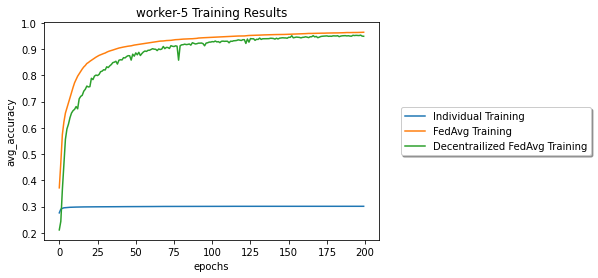

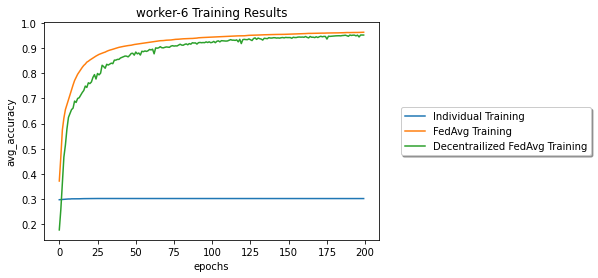

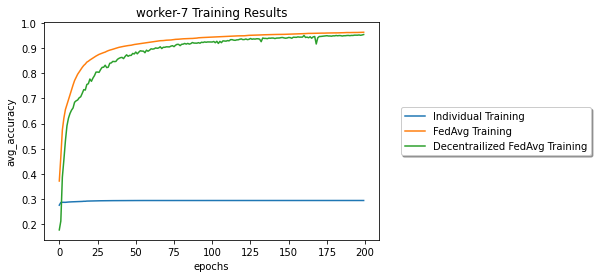

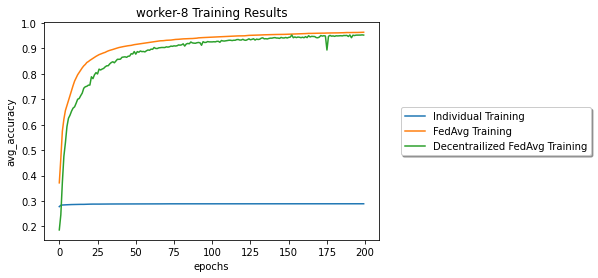

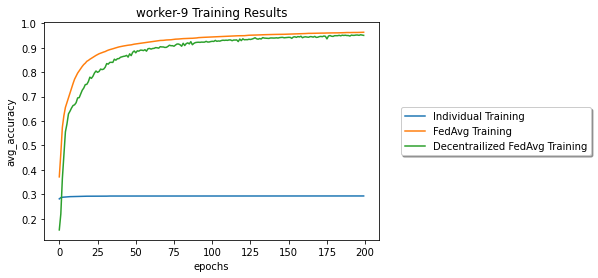

In [23]:
%matplotlib inline
ind_train_df
fedavg_train_df
decentrailized_fedavg_train_df
for node in compute_nodes[-5:]:
    ind_worker_data  = ind_train_df[ind_train_df['worker_id']==node.id]
    plt.plot(ind_worker_data['epoch_idx'],ind_worker_data['avg_accuracy'], label="Individual Training")

    plt.plot(fedavg_train_df['epoch_idx'],fedavg_train_df['avg_accuracy'], label="FedAvg Training")
    
    decentral_worker_data  = decentrailized_fedavg_train_df[decentrailized_fedavg_train_df['worker_id']==node.id]
    plt.plot(decentral_worker_data['epoch_idx'],decentral_worker_data['avg_accuracy'], label="Decentrailized FedAvg Training")
    
    plt.xlabel('epochs')
    # Set the y axis label of the current axis.
    plt.ylabel('avg_accuracy')
    # Set a title of the current axes.
    plt.title(f'{node.id} Training Results')
    # show a legend on the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), shadow=True)
    # Display a figure.
    plt.show()